In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feather
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import forest
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from tpot import TPOTClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
# Helper functions
def rf_feat_importance(m, df):
	return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)


def plot_confusion_matrix(cm, classes,
						  normalize=False,
						  title='Confusion matrix',
						  cmap=plt.cm.Blues):
	"""
	This function prints and plots the confusion matrix.
	Normalization can be applied by setting `normalize=True`.
	"""
	if normalize:
		cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=45)
	plt.yticks(tick_marks, classes)

	fmt = '.2f' if normalize else 'd'
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, format(cm[i, j], fmt),
				 horizontalalignment="center",
				 color="white" if cm[i, j] > thresh else "black")

	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.tight_layout()


def evaluate(model, test_features, test_labels):
    accuracy = model.score(test_features, test_labels)
    mse = mean_squared_error(test_labels, model.predict(test_features))

    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(accuracy))
    print('Mean Squared Error = {:0.4f}%.'.format(mse))
    if hasattr(model, 'oob_score_'):
        print(f'Out of bag score: {model.oob_score_}')
    return accuracy

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
forest.check_random_state(rs).randint(0, n_samples, n))

In [3]:
featurized_files = sorted(glob('tmp/last_fold/featurized_*'))
target_files = sorted(glob('tmp/last_fold/target_*'))
df_list = list()
target_list = list()
for target_file, feat_file in zip(target_files, featurized_files):
    df_list.append(feather.read_dataframe(feat_file))
    target_list.append(feather.read_dataframe(target_file))
    
features = pd.concat(df_list)
targets = pd.concat(target_list) 

In [4]:
featurized_files, target_files

(['tmp/last_fold/featurized_1',
  'tmp/last_fold/featurized_10',
  'tmp/last_fold/featurized_2',
  'tmp/last_fold/featurized_3',
  'tmp/last_fold/featurized_4',
  'tmp/last_fold/featurized_5',
  'tmp/last_fold/featurized_6',
  'tmp/last_fold/featurized_7',
  'tmp/last_fold/featurized_8',
  'tmp/last_fold/featurized_9'],
 ['tmp/last_fold/target_featurized_1',
  'tmp/last_fold/target_featurized_10',
  'tmp/last_fold/target_featurized_2',
  'tmp/last_fold/target_featurized_3',
  'tmp/last_fold/target_featurized_4',
  'tmp/last_fold/target_featurized_5',
  'tmp/last_fold/target_featurized_6',
  'tmp/last_fold/target_featurized_7',
  'tmp/last_fold/target_featurized_8',
  'tmp/last_fold/target_featurized_9'])

In [5]:
targets = targets['valid']

In [6]:
targets.value_counts()

1    5049
0    4951
Name: valid, dtype: int64

In [7]:
def split_vals(df, n): return df[:n], df[n:]
features, X_valid = split_vals(features, 9000)
targets, y_valid = split_vals(targets, 9000)

In [8]:
na_cols = features.columns[features.isna().any()]
features.drop(axis=1, columns=na_cols, inplace=True)

In [9]:

X_train, X_test = split_vals(features, 7000)
y_train, y_test = split_vals(targets, 7000)

In [10]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('bool')], dtype=object)

In [35]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
clf.score(X_train,y_train)

1.0

In [37]:
evaluate(clf, X_test, y_test)

Model Performance
Accuracy = 0.8140%.
Mean Squared Error = 0.1860%.


0.814

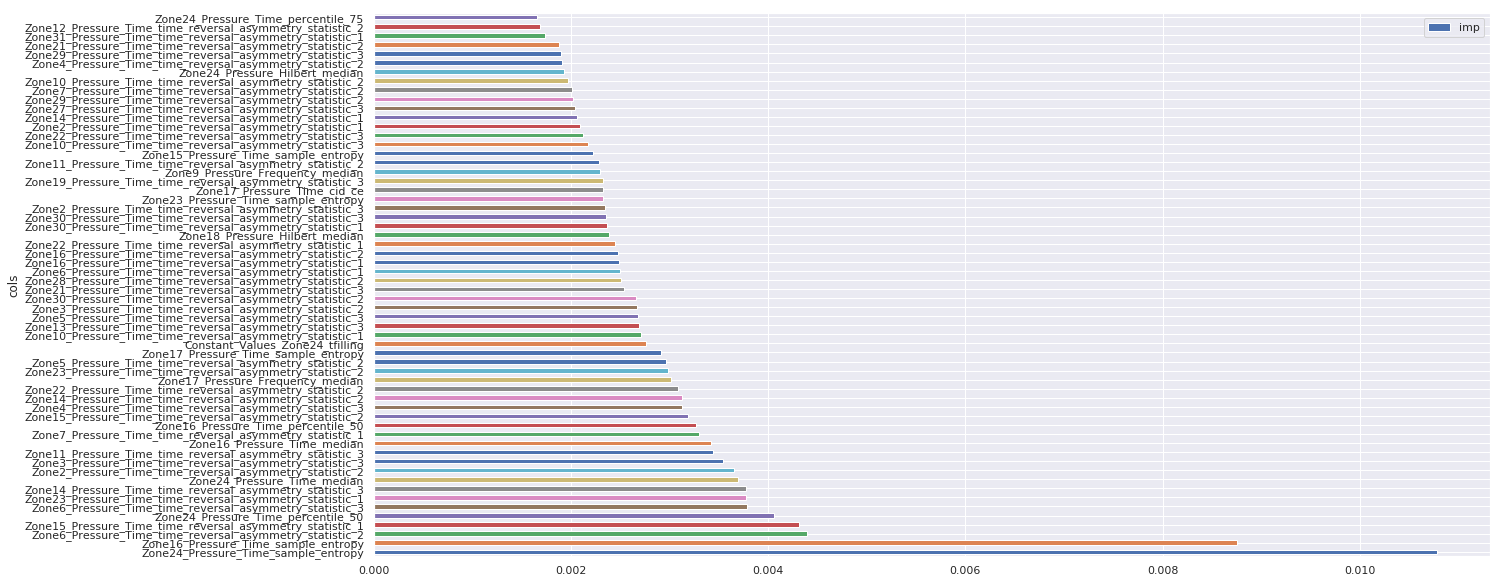

In [38]:
fi = rf_feat_importance(clf, X_test)
fi[:60].plot( 'cols', 'imp','barh', figsize=(20,10))


### Kendu korrelazio handiko zutabeak

In [11]:
import pandas as pd
import numpy as np

def find_correlation(data, threshold=0.9, remove_negative=False):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value.
    remove_negative: Boolean
        If true then features which are highly negatively correlated will
        also be returned for removal.
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.corr()
    if remove_negative:
        corr_mat = np.abs(corr_mat)
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [12]:
correlated_cols = find_correlation(X_train, threshold=0.95)
non_cor_features = features.drop(axis=1, columns=set(correlated_cols))
X_train, X_test = split_vals(non_cor_features, 7000)

In [13]:
X_train.shape

(7000, 1089)

### TPOT training

In [14]:
clf = TPOTClassifier( generations=20, population_size=20, n_jobs=-1, verbosity=2)

clf.fit(X_train, y_train)

clf.export('konposite_tpot_last_fold.py')

Optimization Progress:  12%|█▏        | 50/420 [20:01<45:27:22, 442.28s/pipeline]

Generation 1 - Current best internal CV score: 0.828713943950263


Optimization Progress:  18%|█▊        | 75/420 [30:21<29:40:15, 309.61s/pipeline]

Generation 2 - Current best internal CV score: 0.828713943950263


Optimization Progress:  24%|██▎       | 99/420 [38:18<19:53:43, 223.13s/pipeline]

Generation 3 - Current best internal CV score: 0.828713943950263


Optimization Progress:  29%|██▉       | 123/420 [1:02:10<44:25:39, 538.52s/pipeline]

Generation 4 - Current best internal CV score: 0.828713943950263


Optimization Progress:  35%|███▌      | 147/420 [1:10:58<26:00:44, 343.02s/pipeline]

Generation 5 - Current best internal CV score: 0.828713943950263


Optimization Progress:  40%|████      | 170/420 [1:23:47<24:10:25, 348.10s/pipeline]

Generation 6 - Current best internal CV score: 0.828713943950263


Optimization Progress:  46%|████▌     | 193/420 [1:31:14<11:10:12, 177.15s/pipeline]

Generation 7 - Current best internal CV score: 0.828713943950263


Optimization Progress:  52%|█████▏    | 220/420 [1:41:13<10:12:58, 183.89s/pipeline]

Generation 8 - Current best internal CV score: 0.828713943950263


Optimization Progress:  58%|█████▊    | 245/420 [1:57:35<11:32:30, 237.43s/pipeline]

Generation 9 - Current best internal CV score: 0.828713943950263


Optimization Progress:  63%|██████▎   | 266/420 [2:04:30<10:18:00, 240.78s/pipeline]

Generation 10 - Current best internal CV score: 0.828713943950263


Optimization Progress:  69%|██████▉   | 290/420 [2:15:33<7:50:53, 217.34s/pipeline] 

Generation 11 - Current best internal CV score: 0.828713943950263


Optimization Progress:  75%|███████▍  | 313/420 [2:23:10<5:12:04, 174.99s/pipeline]

Generation 12 - Current best internal CV score: 0.828713943950263


Optimization Progress:  80%|████████  | 337/420 [2:31:52<5:34:53, 242.08s/pipeline]

Generation 13 - Current best internal CV score: 0.828713943950263


Optimization Progress:  87%|████████▋ | 364/420 [2:45:35<5:40:50, 365.18s/pipeline]

Generation 14 - Current best internal CV score: 0.828713943950263


Optimization Progress:  92%|█████████▏| 386/420 [2:53:50<2:23:25, 253.10s/pipeline]

Generation 15 - Current best internal CV score: 0.828713943950263


Optimization Progress:  98%|█████████▊| 413/420 [3:08:22<40:38, 348.35s/pipeline]  

Generation 16 - Current best internal CV score: 0.828713943950263


Optimization Progress: 436pipeline [3:17:28, 333.96s/pipeline]                   

Generation 17 - Current best internal CV score: 0.828713943950263


Optimization Progress: 460pipeline [3:27:26, 253.04s/pipeline]

Generation 18 - Current best internal CV score: 0.828713943950263




TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=7, min_child_weight=16, n_estimators=100, nthread=1, subsample=1.0)


True

In [21]:
clf = XGBClassifier(learning_rate=0.5, max_depth=7, min_child_weight=16, n_estimators=100, n_jobs=8)
clf.fit(X_train, y_train)
evaluate(clf, X_test, y_test)

Model Performance
Accuracy = 0.8550%.
Mean Squared Error = 0.1450%.


0.855

In [24]:
from sklearn.feature_selection import RFECV

clf = XGBClassifier(learning_rate=0.5, max_depth=7, min_child_weight=16, n_estimators=100, n_jobs=6)
rfe = RFECV(clf, step=10, cv=5)
fit = rfe.fit(X_train,y_train )

In [25]:
rfe_features = non_cor_features.loc[:, rfe.get_support()]

In [26]:
X_train, X_test = split_vals(rfe_features, 7000)


In [27]:
import pickle

with open('tmp/important_colums_folded.pickle', 'wb') as f:
    pickle.dump(list(X_train.columns), f)

In [28]:
import pickle

with open('tmp/important_colums_folded.pickle', 'rb') as f:
    important_columns = pickle.load(f)
    
rfe_features = features[important_columns]
rfe_features.shape

(9000, 159)

In [29]:
X_train, X_test = split_vals(rfe_features, 7000)
y_train, y_test = split_vals(targets, 7000)

In [30]:
exported_pipeline = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.85, min_samples_leaf=18, min_samples_split=9, n_estimators=1000, subsample=0.65)

exported_pipeline.fit(X_train, y_train)
evaluate(exported_pipeline, X_test, y_test)

Model Performance
Accuracy = 0.8445%.
Mean Squared Error = 0.1555%.


0.8445

In [31]:
clf = XGBClassifier(learning_rate=0.5, max_depth=7, min_child_weight=16, n_estimators=100, n_jobs=6)

clf.fit(X_train, y_train)
evaluate(clf, X_test, y_test)
print(clf.score(X_train, y_train))

Model Performance
Accuracy = 0.8510%.
Mean Squared Error = 0.1490%.
1.0


In [97]:
clf = XGBClassifier(n_jobs=-1, max_depth=20, n_estimators=1000)

clf.fit(X_train, y_train)
evaluate(clf, X_test, y_test)
print(clf.score(X_train, y_train))

Model Performance
Accuracy = 0.8520%.
Mean Squared Error = 0.1480%.
1.0


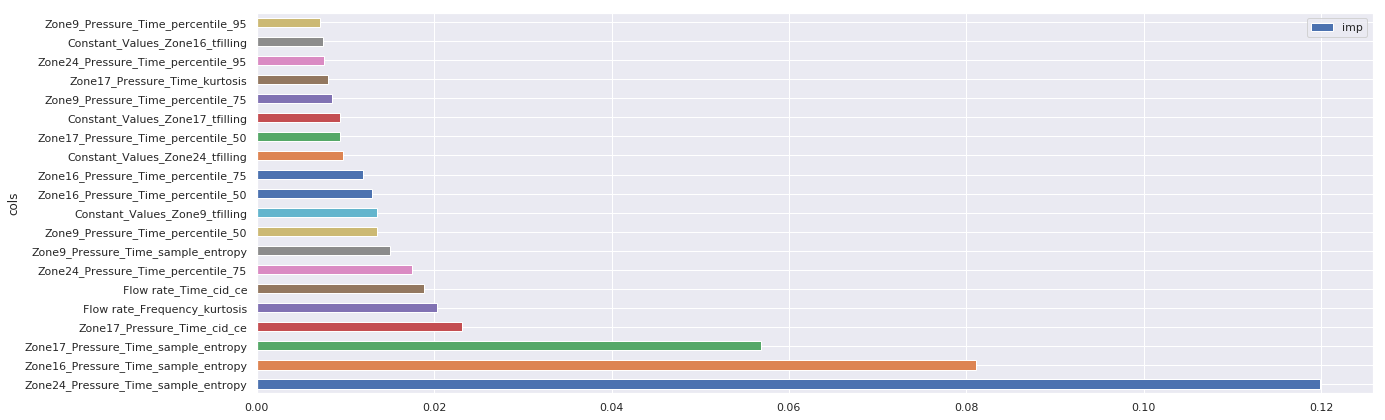

In [53]:

fi = rf_feat_importance(df=X_train, m=exported_pipeline)

fi[:20].plot('cols', 'imp', 'barh', figsize=(20,7))
plt.show()

In [54]:
important_features = features[fi[:60].cols]

In [55]:
X_train, X_test = split_vals(important_features, 7000)

In [56]:
X_train.shape

(7000, 60)

In [57]:
train_eval = []
test_eval = []

for i in range(len(fi)):
    imp_feats = features[fi[:i].cols]
    X_train, X_test = split_vals(imp_feats, 7000)
    clf = XGBClassifier(n_jobs=-1, max_depth=20, n_estimators=100)
    clf.fit(X_train, y_train)
    test_eval.append(clf.score(X_test, y_test))
    train_eval.append(clf.score(X_train, y_train))

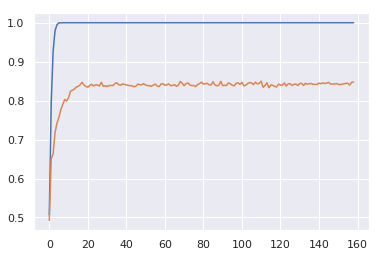

In [58]:
plt.plot(train_eval)
plt.plot(test_eval)
plt.show()

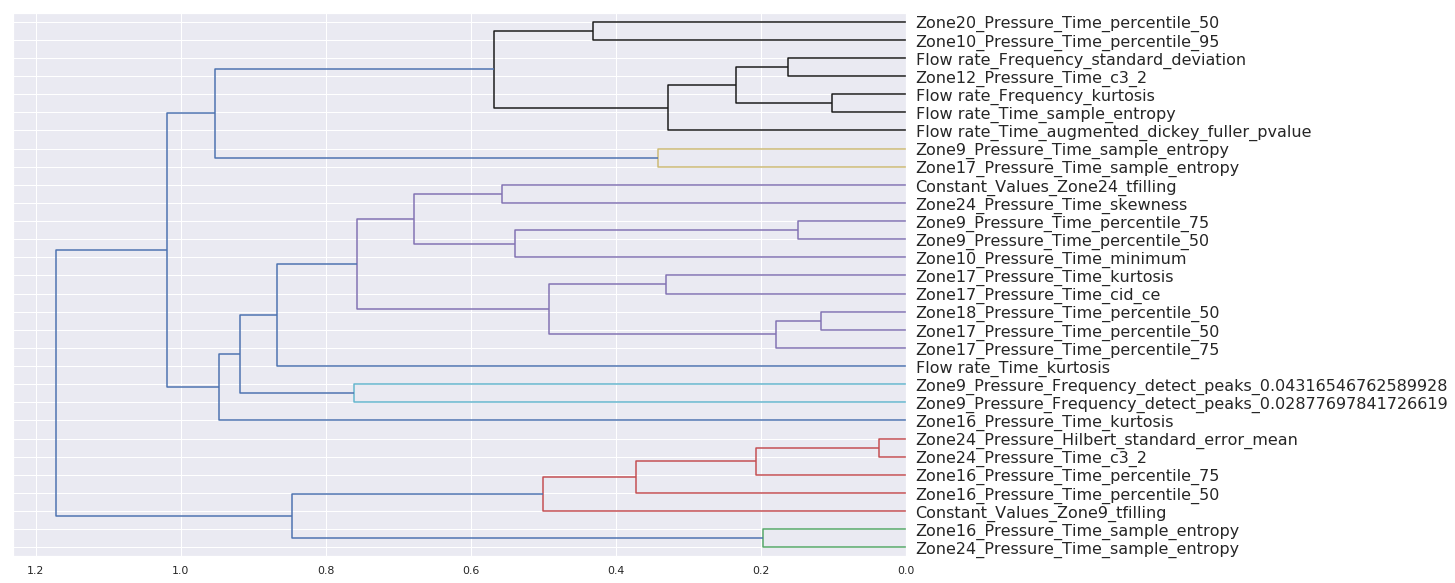

In [27]:

import scipy as sp
from scipy.cluster import hierarchy as hc

corr = np.round(sp.stats.spearmanr(important_features).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=important_features.columns, orientation='left', leaf_font_size=16)
plt.show()


In [143]:
from sklearn.metrics import roc_curve, auc
def auc_curve_plot(model, x, y):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(y, model.predict_proba(x)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [1]:

def objective( space):

    clf = XGBClassifier(**space,n_jobs=-1)
    eval_set  = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train,eval_set=eval_set, eval_metric="logloss", early_stopping_rounds=30, verbose=False)
    score = clf.score(X_test, y_test)

    return{'loss':1-score, 'status': STATUS_OK }


the AUC is : 0.9049


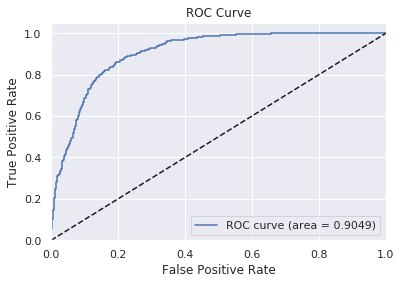

In [99]:
clf = XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
auc_curve_plot(clf, X_test, y_test)

In [102]:
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials



space ={
        "learning_rate"    : hp.uniform('x_learning_rate', 0.05, 0.30) ,
         "gamma"            : hp.uniform('x_gamma', 0.0, 0.5),
         "colsample_bytree" : hp.uniform('x_colsample_bytree', 0.3, 0.7),
        'max_depth': scope.to_int(hp.quniform("x_max_depth", 3, 15, 1)),
        'min_child_weight': hp.quniform ('x_min_child', 1, 7, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'n_estimators': hp.choice('n_estimators', range(100,600)),

    
    }
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

100%|██████████| 100/100 [11:25<00:00,  8.08s/it, best loss: 0.12849999999999995]


In [103]:
best

{'n_estimators': 227,
 'x_colsample_bytree': 0.5547458832571559,
 'x_gamma': 0.2520852942466917,
 'x_learning_rate': 0.055427523005628726,
 'x_max_depth': 9.0,
 'x_min_child': 5.0,
 'x_subsample': 0.9988436385974631}

In [156]:
clf = XGBClassifier(n_estimators=1000, max_depth=9, min_child_weight=5,learning_rate=0.05, gamma=0.25,colsample_bytree=0.5,
                    n_jobs=-1)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.25, learning_rate=0.05,
       max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

the AUC is : 0.9395


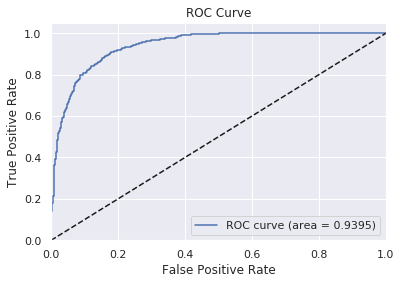

In [157]:
auc_curve_plot(clf, X_test, y_test)

In [158]:
evaluate(clf, X_test, y_test)
print(clf.score(X_train, y_train))

Model Performance
Accuracy = 0.8605%.
Mean Squared Error = 0.1395%.
1.0


In [159]:
fi = rf_feat_importance(m=clf, df=X_train)

## Overfittinga kentzeko, feature batzuk kenduko ditugu

In [172]:
imp_features = features[fi[:50].cols]
X_train, X_test = split_vals(imp_features, 7000)
X_valid = X_valid[fi[:50].cols]

In [168]:
clf = XGBClassifier(n_estimators=300, max_depth=9, min_child_weight=5,learning_rate=0.05, gamma=0.25,colsample_bytree=0.5,
                    n_jobs=-1)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.25, learning_rate=0.05,
       max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
       n_estimators=300, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

the AUC is : 0.9362


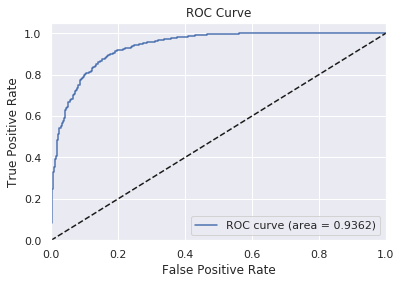

In [169]:
auc_curve_plot(clf, X_test, y_test)


the AUC is : 0.9369


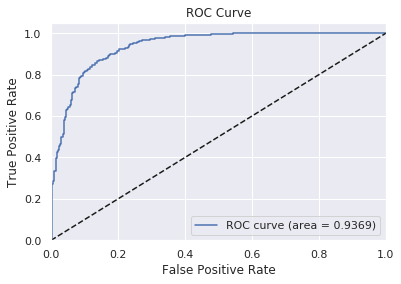

In [173]:
auc_curve_plot(clf, X_valid, y_valid)


In [174]:
evaluate(clf, X_test, y_test)
evaluate(clf, X_valid, y_valid)
print(clf.score(X_train, y_train))

Model Performance
Accuracy = 0.8590%.
Mean Squared Error = 0.1410%.
Model Performance
Accuracy = 0.8600%.
Mean Squared Error = 0.1400%.
0.997


In [58]:
clf = XGBClassifier(n_estimators=300, max_depth=3, min_child_weight=4,learning_rate=0.1, gamma=0.25,colsample_bytree=0.5,
                    n_jobs=-1)
clf.fit(X_train, y_train)


Model Performance
Accuracy = 0.8415%.
Mean Squared Error = 0.1585%.
0.912


In [80]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)


/home/joanes/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

the AUC is : 0.8749


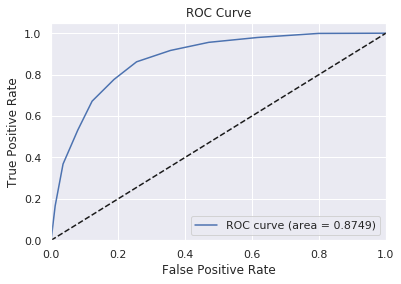

In [81]:
auc_curve_plot(clf, X_test, y_test)

In [82]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [95]:
from sklearn.model_selection import cross_val_score

def objective_rf( space):

    clf = RandomForestClassifier(**space,n_jobs=-1)
    eval_set  = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train,eval_set=eval_set, eval_metric="logloss", early_stopping_rounds=30, verbose=False)
    score = clf.score(X_test, y_test)

    return{'loss':1-score, 'status': STATUS_OK }

param_space = {
    'max_depth': hp.choice('max_depth', range(1,30)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', 'auto', 0.5,0.3]),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'min_samples_split': hp.choice('min_samples_split', [2,5,10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1,2,4]),
}


trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=200, trials=trials)
print ('best:')
print (best)

new best:                                            
0.8347506514162699                                   
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 18, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 386}
new best:                                                                          
0.8362508077639873                                                                 
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 21, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 140}
new best:                                                                          
0.8362508077639873                                                                
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 227}
new best:                                                                         
0.8362508077639873         

KeyboardInterrupt: 

In [96]:
best

0.8362508077639873